#### Import Libraries

In [1]:
import pandas as pd
import urllib
import json
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

#### Create Connection to SQLLite database

In [2]:
conn = sqlite3.connect('ml_project_final.db')

#### POVERTY

In [7]:
poverty_url = 'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,SAEPOVRTALL_PT,SAEPOVALL_PT&for=county:*&time={0}'
years = range(2008,2017)

poverty_final_df = pd.DataFrame()
for year in years:
    poverty_txt = urllib.request.urlopen(poverty_url.format(year)).read() 
    poverty_list = json.loads(poverty_txt)
    current = pd.DataFrame(poverty_list[1:], columns=poverty_list[0]) 
    poverty_final_df = pd.concat((poverty_final_df, current))
poverty_final_df.head(5)

,NAME,SAEPOVRTALL_PT,SAEPOVALL_PT,time,state,county
0,Autauga County,10.7,5366,2008,01,001
1,Baldwin County,9.9,17110,2008,01,003
2,Barbour County,24.5,6399,2008,01,005
3,Bibb County,18.5,3753,2008,01,007
4,Blount County,13.1,7461,2008,01,009


In [4]:
poverty_final_df.shape
poverty_final_df.to_csv('poverty_final.csv')

In [8]:
poverty_final_df['time'].value_counts()

2013    3143
2010    3143
2012    3143
2011    3143
2009    3143
2016    3142
2008    3142
2015    3142
2014    3142
Name: time, dtype: int64

#### HEALTH

In [9]:
health_url = 'https://api.census.gov/data/timeseries/healthins/sahie?get=NIC_PT,NAME,NUI_PT&for=county:*&time={0}'
years = range(2008,2017)

final_health_df = pd.DataFrame()
for year in years:
    health_txt = urllib.request.urlopen(health_url.format(year)).read() 
    health_list = json.loads(health_txt)
    current = pd.DataFrame(health_list[1:], columns=health_list[0]) 
    final_health_df = pd.concat([final_health_df, current])
final_health_df.head(5)

,NIC_PT,NAME,NUI_PT,time,state,county
0,38474,"Autauga County, AL",5880,2008,01,001
1,120301,"Baldwin County, AL",23631,2008,01,003
2,18370,"Barbour County, AL",3934,2008,01,005
3,14321,"Bibb County, AL",3147,2008,01,007
4,39426,"Blount County, AL",9482,2008,01,009


In [10]:
final_health_df.shape
final_health_df.to_csv('health_final.csv')

In [11]:
final_health_df['time'].value_counts()

2013    3143
2010    3143
2012    3143
2011    3143
2009    3143
2016    3142
2008    3142
2015    3142
2014    3142
Name: time, dtype: int64

#### Joining Health and Poverty dataframes to produce ONE data set

In [12]:
fulldata = pd.merge(left=final_health_df, right=poverty_final_df.iloc[:,[1,2,3,4,5]], on=['state', 'county', 'time'], how='inner')
fulldata.head()
fulldata.shape
fulldata['State'] = fulldata['NAME'].apply(lambda State: State.split(',')[-1])
fulldata['County'] = fulldata['NAME'].apply(lambda State: State.split(',')[0])
fulldata.head(5)

fulldata.to_csv('fulldata1.csv')

#### Cleaning Up the dataset

In [13]:
fulldata = fulldata[(fulldata == "N/A").sum(axis=1) == 0].copy()
fulldata.to_csv('full_data_Uni.csv')
fulldata.head()

,NIC_PT,NAME,NUI_PT,time,state,county,SAEPOVRTALL_PT,SAEPOVALL_PT,State,County
0,38474,"Autauga County, AL",5880,2008,01,001,10.7,5366,AL,Autauga County
1,120301,"Baldwin County, AL",23631,2008,01,003,9.9,17110,AL,Baldwin County
2,18370,"Barbour County, AL",3934,2008,01,005,24.5,6399,AL,Barbour County
3,14321,"Bibb County, AL",3147,2008,01,007,18.5,3753,AL,Bibb County
4,39426,"Blount County, AL",9482,2008,01,009,13.1,7461,AL,Blount County


#### Converting some data points to FLOAT for calculations

In [14]:
mydata = fulldata.iloc[:, [0,2,6]].astype(float)
mydata.head()

,NIC_PT,NUI_PT,SAEPOVRTALL_PT
0,38474.0,5880.0,10.7
1,120301.0,23631.0,9.9
2,18370.0,3934.0,24.5
3,14321.0,3147.0,18.5
4,39426.0,9482.0,13.1


#### Adding percentage UnInsured column 

In [15]:
mydata['uninsured_prctn'] = mydata['NUI_PT']/(mydata['NUI_PT'] + mydata['NIC_PT'])*100
mydata.head()

,NIC_PT,NUI_PT,SAEPOVRTALL_PT,uninsured_prctn
0,38474.0,5880.0,10.7,13.256978
1,120301.0,23631.0,9.9,16.418170
2,18370.0,3934.0,24.5,17.638092
3,14321.0,3147.0,18.5,18.015800
4,39426.0,9482.0,13.1,19.387421


#### "X" FEATURE (% POVERTY) , column 3(index 2). Make a numpy array

In [16]:
X = mydata.iloc[:,[2]].values
X

array([[10.7],
       [ 9.9],
       [24.5],
       ...,
       [10.6],
       [13.1],
       [10.7]])

#### "y" TARGET(% UNINSURED) , column 4(index 3), make a numpy array

In [17]:
y = mydata.iloc[:,3].values
#y = mydata.iloc[:,[3]].values
y

array([13.25697795, 16.41816969, 17.63809182, ..., 12.56897609,
       16.70822943, 14.35218325])

#### Find correlation between Poverty and Uninsured, using Python "corr" function.
#### Corelations are from -1 to +1 (-1 means -ve corelation, +1 means +ve corelation)
#### Based on the corelation results below there appears to be a 42% corelation between % Poverty and % Uninsured 

In [18]:
mydata.iloc[:,[2,3]].corr()

,SAEPOVRTALL_PT,uninsured_prctn
SAEPOVRTALL_PT,1.000000,0.421399
uninsured_prctn,0.421399,1.000000


#### Adding Log of poverty and uninsured Transformation to the dataframe
#### Based on results below the corelation now is 47 %

In [19]:
mydata['Log_uninsured_prctn'] = np.log(mydata['uninsured_prctn'])
mydata['Log_SAEPOVRTALL_PT'] = np.log(mydata['SAEPOVRTALL_PT'])
mydata.iloc[:,[4,5]].corr()

,Log_uninsured_prctn,Log_SAEPOVRTALL_PT
Log_uninsured_prctn,1.00000,0.47062
Log_SAEPOVRTALL_PT,0.47062,1.00000


In [20]:
mydata.to_csv('project_data_NONEED.csv')

#### Applying ML methodologies. Split the data into two groups Train and Test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=50)
X_test

array([[16.1],
       [27.1],
       [18.9],
       ...,
       [38.2],
       [20.6],
       [28.7]])

#### Create a Linear Regression Object

In [31]:
lr = LinearRegression()

#### Train the model

In [32]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Accuracy of the test data

In [33]:
#lr.score(X_train, y_train) which one to use for r2 score : train or test
# r-squared is between 0 and 1, higher is better in terms of performance
lr.score(X_test, y_test) 

0.17529509912152896

#### Predict (uninsured) based on the known Poverty data

In [34]:
#### Predicted values(should this be with test data , train data or original data)
#y_pred = lr.predict(X)
y_pred = lr.predict(X)
y_pred

array([13.80606643, 13.48233717, 19.39039618, ..., 13.76560027,
       14.77725421, 13.80606643])

In [35]:
#### Scatter plot uninsured_percent and poverty_percent
#### Non Logarithmic data values

Text(0.5,1,'Scatter Plot Uninsured vs Poverty(Non Logarithmic data)')

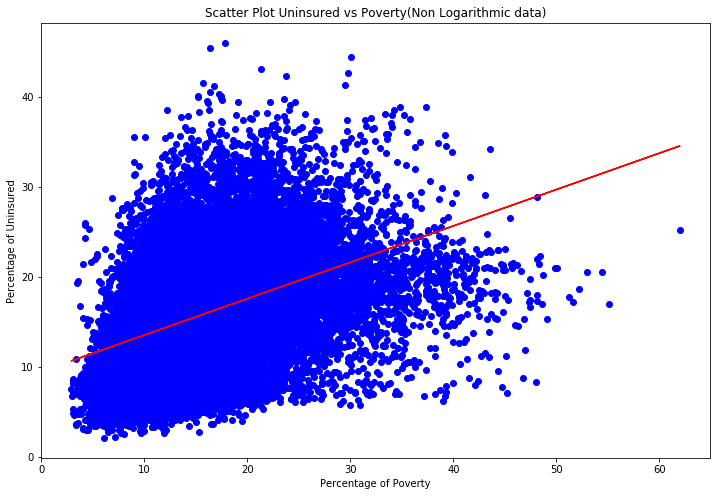

In [36]:
plt.figure(figsize=(12,8))
plt.plot(X, y, 'bo')
#plt.plot(X_test, y_test, 'bo', alpha = 0.5)
plt.plot(X,y_pred, 'r-')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured')
plt.title('Scatter Plot Uninsured vs Poverty(Non Logarithmic data)')

In [28]:
#### Histogram of Non Log poverty and Uninsured , notice long tail

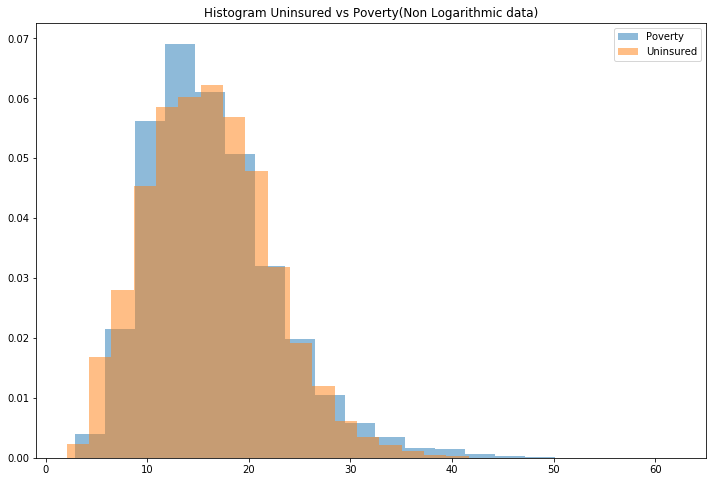

In [37]:
plt.figure(figsize=(12,8))
plt.hist(X, bins=20, density=True, label='Poverty', alpha = 0.5)
plt.hist(y, bins=20, density=True, label='Uninsured', alpha = 0.5)
#plt.hist(X_test, bins=20, density=True, label='Poverty', alpha = 0.5)
#plt.hist(y_test, bins=20, density=True, label='Uninsured', alpha = 0.5)
plt.title('Histogram Uninsured vs Poverty(Non Logarithmic data)')
plt.legend()

#### Scatter plot of the LOGARITHMIC values of Uninsured vs Poverty

In [38]:
X_log = np.log(X)
y_log = np.log(y)

#### Histogram of the LOG values of Uninsured vs Poverty, shape is closer to a Bell Curve

#### Split the LOG data into test and train

In [44]:
X_log_train, X_log_test, y_log_train, y_log_test = \
        train_test_split(X_log, y_log, test_size=0.20, random_state=50)

In [45]:
X_log_test

array([[2.77881927],
       [3.29953373],
       [2.93916192],
       ...,
       [2.10413415],
       [2.61006979],
       [3.09557761]])

#### Create a Linear Regression Object

In [46]:
lr = LinearRegression()

#### Train the model

In [47]:
lr.fit(X_log_train, y_log_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
lr.score(X_log_test, y_log_test)

0.21439482488664519

In [49]:
#y_log_pred = lr.predict(X_log_test) ###Graph does not plot with this!
y_log_pred = lr.predict(X_log)  

Text(0.5,1,'Scatter of the LOG of Uninsured vs Poverty ')

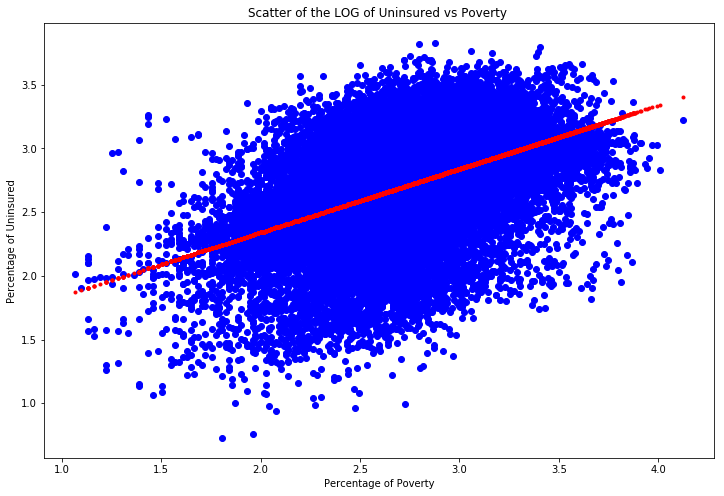

In [50]:
plt.figure(figsize=(12,8))
plt.plot(X_log, y_log, 'bo')
plt.plot(X_log,y_log_pred, 'r.')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured') 
plt.title('Scatter of the LOG of Uninsured vs Poverty ')

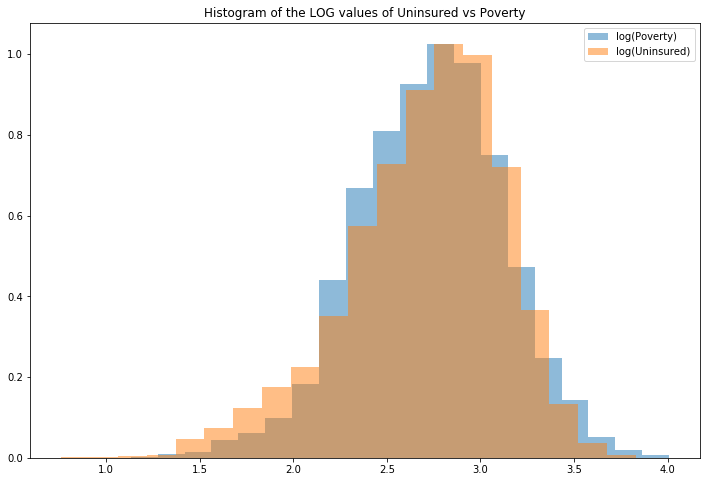

In [52]:
plt.figure(figsize=(12,8))
plt.hist(X_log_test, bins=20, density=True, label='log(Poverty)', alpha = 0.5)
plt.hist(y_log_test, bins=20, density=True, label='log(Uninsured)', alpha = 0.5)
plt.title('Histogram of the LOG values of Uninsured vs Poverty')
plt.legend()

## Final Analysis of the Univariant Linear Regression 
#### We see a positive correlation between % of poverty and % of uninsured people. It means that
#### there is a direct relationship between these two parameters. In other words, if % of poverty
#### goes up, the % of unisnured people is also goes up. However, the correlation value is only 0.42 (linear) to 0.47 (logarithmic)
#### which means the correlation is fairly strong. Also from the regression R2, we get 0.17(linear) to 0.22 (log) 
#### which is not very good. Therefore, it seems modeling the exact % of uninsured people from % of poverty is difficult, but
#### the graph and correlation show a positive relationship.

# Random Forest

In [53]:
myrf = RandomForestRegressor()

In [54]:
myrf.fit(X_train, y_train)
myrf.score(X_test, y_test)

0.19036809835013613

In [55]:
y_pred = myrf.predict(X)

In [56]:
# random forest prediction does not fall on a straight line and can have any shape

Text(0.5,1,'Random Forest')

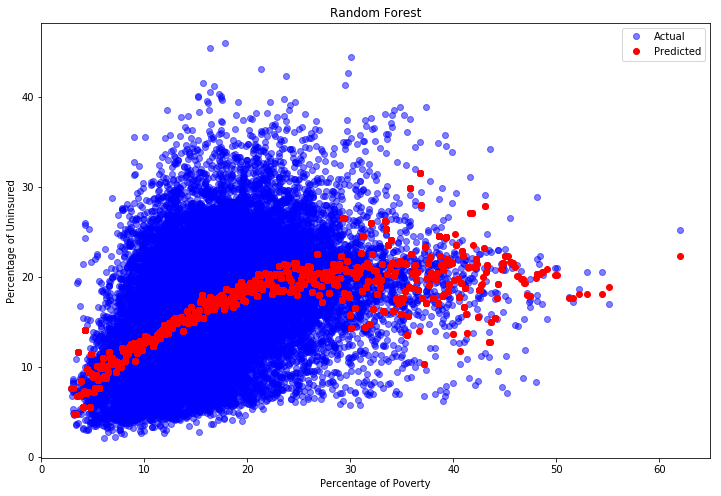

In [57]:
plt.figure(figsize=(12,8))
plt.plot(X, y, 'bo', label='Actual', alpha = 0.5)
#plt.plot(X_test, y_test, 'bo', alpha = 0.5)
plt.plot(X,y_pred, 'ro', label='Predicted')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured')
plt.title('Scatter Plot Uninsured vs Poverty(Non Logarithmic data)')
plt.legend()
plt.title('Random Forest')